## Case Study - Comparing Accuracy for Real-Time Face Detection Models

The goal of this case study is to figure out what the best model would be for real-time face detection. More specifically, what model detect images more accurately. Instead of using a video, this study use a set of images instead of videos. The model will only be robust if it is tested on a set of images that are diverse in lighting condition, position of the faces, amount of faces, skin color, etc. Videos is essentially a finite set of frames (images) put together. The argument is that a diverse set of images will test the accuracy better than a video would do. <br>

The face detection models compared will be: 
- Haar Cascade
- HOG
- DNN

These detection models will also be compared against the following library: 
- CVZone

All of the will be within the folder `data/test_data/` in the same repository. See the [Dataset Section](#3-the-dataset). Run the following code block to import all libraries: 

In [1]:
# Importing packages for CV2, DLIB and Plotting 
import cv2
import dlib
import matplotlib.pyplot as pyplot

# For benchmarking the process of generating the graph
import time

# For creating the progress bar when looping over the dataset
from tqdm.notebook import tqdm

# Import for cvzone 
from cvzone.FaceMeshModule import FaceMeshDetector

### 1. Code snippets for each model

The following code are the function for each face detection model. The code for the individual models can be found in within `src/models/code/` the `OpenCV_Server` repository. Each file has a function that is called on a single frame. The output is either a list of boundary boxes (`Rect`) or `None`. The functions are moved over to this file for the sake of simplicity.

Run this block to correctly find and import the functions:

In [2]:
import sys 
sys.path.append('../src')

# Importing the functions for the face detection models 
from models.code.dnn import detect_face_dnn
from models.code.haar import detect_face_haar
from models.code.hog import detect_face_hog
from models.code.cvzone import detect_face_cvzone

### 2. Metrics for Quantifying Face Detection Accuracy

FOr assessing the accuracy of face detection methods, it is crucial to measure metrics that effectively capture the accuracy of the detection algorithms. These metrics provide a standardized way to evaluate and compare different face detection methods. The following metrics are some more common metrics:

- **Intersection over Union (IoU):** This metric evaluates the overlap between the predicted bounding box and the ground truth (actual) bounding box. It measures the ratio of the area of overlap to the area of union between the two boxes. A good detection algorithm should place the bounding box directly over the ground truth bounding box. 

- **Precision:** Precision measures the correctness of the predicted positive identifications. It is defined as the proportion of true positive detections out of all positive detections made by the face detection method. This metric highlights the algorithm's ability to minimize false positives. 

- **Recall:**  The metric tries to assesses the algorithm's ability to detect all faces. It is calculated as the true positive detections divided by the total actual positives in the dataset. High recall indicates the model's effectiveness in identifying faces without missing many faces.

Given the focus of our case study, we prioritized **recall** as the primary metric of our analysis. This requires counting the number of faces correctly identified by each method divided by the total number of real faces in the data set.

### 3. The Dataset

For the accuracy test we are going to use a dataset with 5171 faces in a set of 2845 images. The dataset is called FDDB: Face Detection Data Set and Benchmark, and was created by the University of Massachusetts. A link to the dataset can be found in the [resources](#resources). 


The images has to be extracted in the path `data/test_data/FDDB/`. This folder is git ignored, meaning that setup is required before running this Jupiter Hub file. Create a new directory within the `data/test_data`, called `FDDB`. This is a huge dataset with over 28 000 images. Not all where used in the FDDB study. The complete list of all images used in the study is located in the file: `data/test_data/fddb_paths.txt`. The file has the paths for the 2845 images that were used in the study.


To test that the dataset has been correctly imported run the following code blocks (the image is of a golfer with a golf club): 

In [3]:
# Expect 2845 images
total_amount_of_images = 2845
total_amount_of_faces = 5171
actual = 0

# Count how many lines there is in the list of all images used by the 
with open("../data/test_data/fddb_paths.txt", "r") as file:
    actual = sum(1 for line in file)

# Assert that this is the case
assert actual == total_amount_of_images

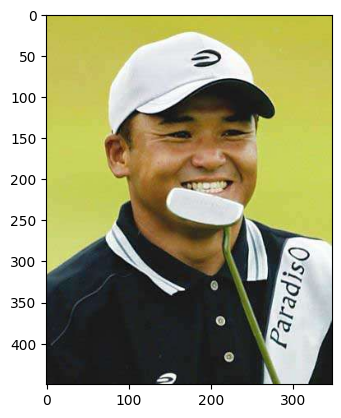

In [4]:
# Opening the first image in the dataset 
path = "../data/test_data/FDDB/2002/07/19/big/img_65.jpg"

# Opening the image and reading the image for the correct model
img = cv2.imread(path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Showing the image (should be no error)
pyplot.imshow(img)

### 4. Comparing the models 

For comparing, all models are going to iterate over the same images. A perfect model will detect all 5171 faces. All models will be given the same image and tries to find faces. Then the percentage of how many faces he detected will be 

In [5]:
# The dataset folder: 
dataset_folder = "../data/test_data/FDDB"

# Variable for counting how many images was processed 
image_count = 0

# Start benchmarking 
start_time = time.time()

# Variables for the data
haar_positives = 0
hog_positives = 0
dnn_positives = 0 
cvzone_positives = 0

# Setup NET for DNN
modelFile = "../src/models/trained_models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "../src/models/trained_models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

# Setting up the detectors for Haar, Hog and cvzone
haar_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
hog_detector = dlib.get_frontal_face_detector()
cvzone_detector = FaceMeshDetector()


# Initialize the progress bar
progress_bar = tqdm(total=total_amount_of_images, desc="Processing Images")


# Walk through all directories and files in the folder
with open("../data/test_data/fddb_paths.txt", "r") as file:
    for path in file: 
        # Increment the image count
        image_count += 1

        # Full path 
        image_path = "../data/test_data/FDDB/" + path.strip() + ".jpg"

        # Read image and correct color
        img = cv2.imread(image_path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Test Haar Method 
        faces_haar = detect_face_haar(img, haar_detector, detect_multiple_faces=True)
        if faces_haar is not None and len(faces_haar) > 0:
            haar_positives += len(faces_haar) 

        # Test HOG Method 
        faces_hog = detect_face_hog(img, hog_detector, detect_multiple_faces=True)
        if faces_hog is not None and len(faces_hog) > 0:
            hog_positives += len(faces_hog)

        # Test DNN Method
        faces_dnn = detect_face_dnn(img, net, framework="caffe", conf_threshold=0.89, detect_multiple_faces=True)
        if faces_dnn is not None and len(faces_dnn) > 0:
            dnn_positives += len(faces_dnn)


        # Test CVzone Method
        faces_cvzone = detect_face_cvzone(img,cvzone_detector,detect_multiple_faces=True)
        if faces_cvzone is not None and len(faces_cvzone) > 0:
            if len(faces_cvzone) == 468:
                cvzone_positives += 1
            else:
                cvzone_positives += len(faces_cvzone)
        
        # Update the progress bar
        progress_bar.update(1)

# Stop the progress bar
progress_bar.close()

# End benchmarking time
end_time = time.time()
seconds_passed = round(end_time - start_time, 0)
min, sec = divmod(seconds_passed, 60)


# Print metrics of process 
print(f"Images processed: {image_count}")
print(f"Time elapsed:   {min} min, {sec}s")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Processing Images:   0%|          | 0/2845 [00:00<?, ?it/s]

Images processed: 2845
Time elapsed:   4.0 min, 21.0s


Calculating the result **R** as a percentage (rounded to two decimals): 
$$
  R = \frac{\text{Amount of detected faces}}{\text{Total amount of faces}} \times 100
$$

In [6]:
# Calculating the percentage of each individual method 
haar_res = round((haar_positives / total_amount_of_faces) * 100, 2)
hog_res = round((hog_positives / total_amount_of_faces) * 100, 2)
dnn_res = round((dnn_positives / total_amount_of_faces) * 100, 2)
cvzone_res = round((cvzone_positives / total_amount_of_faces) * 100, 2)

# Printing the result
print(f"HAAR: {haar_res}% of faces detected ")
print(f"HOG: {hog_res}% of faces detected ")
print(f"DNN: {dnn_res}% of faces detected ")
print(f"CVZone: {cvzone_res}% of faces detected ")

HAAR: 66.7% of faces detected 
HOG: 75.83% of faces detected 
DNN: 82.09% of faces detected 
CVZone: 53.39% of faces detected 


Using `matplotlib` to plot the data in a horizontal bar graph: 

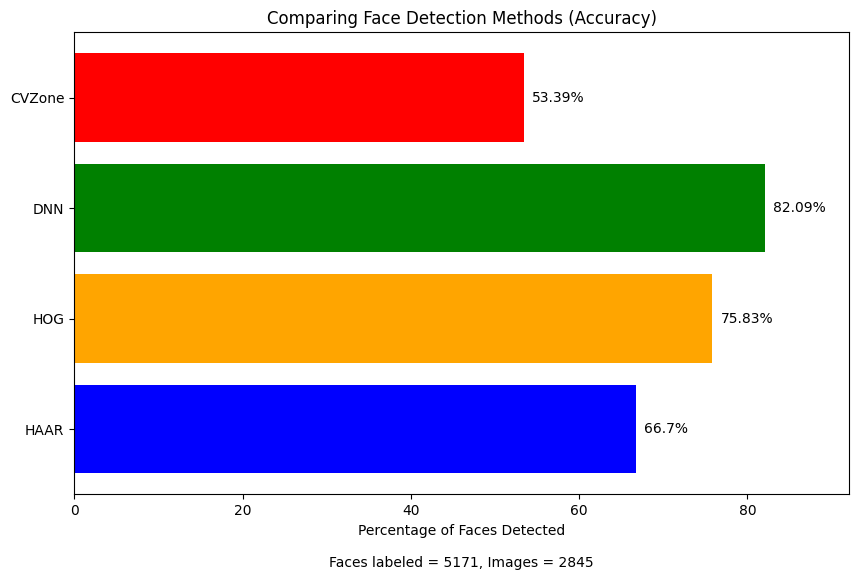

In [7]:
# Setting up labels and values to plot (x, y axis labels)
methods = ["HAAR", "HOG", "DNN", "CVZone"]
percentages = [haar_res, hog_res, dnn_res, cvzone_res]

# Creating the horizontal bar chart
pyplot.figure(figsize=(10, 6))
bars = pyplot.barh(methods, percentages, color=["blue", "orange", "green", "red"])

# Adding the text labels on the bars
for bar in bars:
    # Set labels to the left of the bar
    width = bar.get_width()
    label_x_pos = width + 1 

    # Plotting the bar
    pyplot.text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width}%", va="center")

# Setting the labels and title
pyplot.xlabel(f"Percentage of Faces Detected\n\nFaces labeled = {total_amount_of_faces}, Images = {total_amount_of_images}")
pyplot.title("Comparing Face Detection Methods (Accuracy)")

# Adjust the x-axis limits if you want more space for text
pyplot.xlim(0, max(percentages) + 10)  # Adding 10 for a bit of extra space on the right

# Saving the figure to a set path 
pyplot.savefig("../data/results/case_studies/compare_face_detection_model_accuracy.png")

# Showing the figure
pyplot.show()

### Resources: 

Metrics for face detection model comparison: <br>
https://learnopencv.com/what-is-face-detection-the-ultimate-guide/#Metrics-used-for-Face-Detection <br>

The FDDB Dataset with for benchmarking: <br>
http://vis-www.cs.umass.edu/fddb/ 


Check out the GitHub repository here: [GitHub Repository](https://github.com/RIT-NTNU-Bachelor/OpenCV_Server)

**Created by:** Kjetil Indrehus, Sander Hauge and Martin Johannessen
